# Objective

The objective of these project is to build a GAN that generates 7,000 to 10,000 images in the style of Monet.

The general idea behind GANs is that the generator generates an image and the discriminator predicts whether the image is real or fake, until it can no longer differentiate the fake image from a real image.

For this project, we will use CycleGAN, which is aims to learn the mapping between an input image and an output image using a training set of aligned image pairs.

This workbook realise heavily on the tutorial provided by Amy Jang, which was recommended by Kaggle in the competition description: https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial.  The tutorial has MiFID score of 53.76998.  So, that is the score to beat.


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kaggle_datasets import KaggleDatasets
import keras
from keras import layers, ops
import matplotlib.pyplot as plt
import numpy as np
AUTOTUNE = tf.data.experimental.AUTOTUNE

print(tf.__version__)

2.17.1


# Datasets

300 Monet paintings sized 256x256 are provided, along with 7038 photos sized 256x256.  The images are all Red-Green-Blue.

The photos and painting are provided as both JPEGs and TFRecords.  The photos and painting are identical in both formats.  

For more information on the TGRecord format, Kaggle provides a basic description: https://www.kaggle.com/code/ryanholbrook/tfrecords-basics.  In short, TFRecord format is a binary format that allows for efficient splitting of the data to be processed on the different cores of the TPU.

Originally, I used the TFRecords in this project to become more familiar with this format.  However, I had issue running training the model on the TPU in the Kaggle workbook.  The workbook would run, but the model was training on the CPU.  So, I transitioned to the JPEG format to run on GPU.

In [2]:
PATH = '/kaggle/input/gan-getting-started'

In [3]:
MONET_FILENAMES = tf.io.gfile.glob(str(PATH + '/monet_jpg/*.jpg'))
PHOTO_FILENAMES = tf.io.gfile.glob(str(PATH + '/photo_jpg/*.jpg'))

In [4]:
num_monet_paintings = len(MONET_FILENAMES)
num_photos = len(PHOTO_FILENAMES)

print(f"Number of Monet paintings: {num_monet_paintings}")
print(f"Number of photos: {num_photos}")


Number of Monet paintings: 300
Number of photos: 7038


# Preprocess Images
Covert the images to datasets to be used in to train the models.

Apply some data augmentation, like random cropping and random horizontal flips.

In [5]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

def prepossess_image(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)

  # Random jittering
  image = tf.image.random_crop(image, size=[IMG_WIDTH, IMG_HEIGHT, 3])
  image = tf.image.random_flip_left_right(image)

  return image


In [6]:
BATCH_SIZE = 1
BUFFER_SIZE = 1000

monet_ds = tf.data.Dataset.list_files(MONET_FILENAMES).map(prepossess_image, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
photo_ds = tf.data.Dataset.list_files(PHOTO_FILENAMES).map(prepossess_image, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Below are some examples of Monet paintings

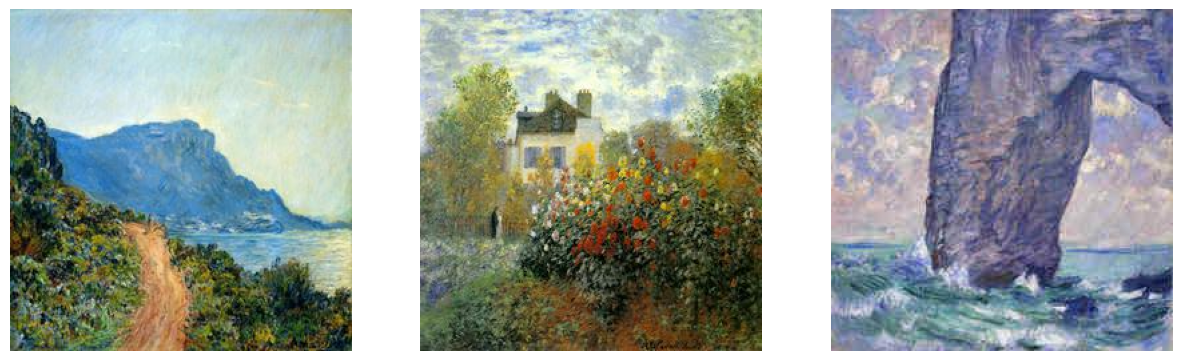

In [7]:
monet_images = []
for i, image in enumerate(monet_ds):
  if i < 3:
    monet_images.append(image[0])
  else:
    break

# Plot the images side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, ax in enumerate(axes):
  ax.imshow(monet_images[i])
  ax.axis('off')

plt.show()


Below are some example photos

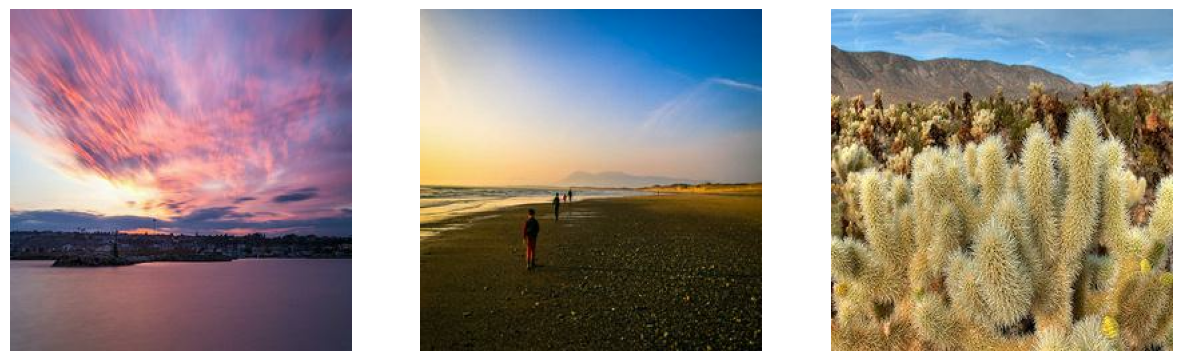

In [8]:
photo_images = []
for i, image in enumerate(photo_ds):
  if i < 3:
    photo_images.append(image[0])
  else:
    break

# Plot the images side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, ax in enumerate(axes):
  ax.imshow(photo_images[i])
  ax.axis('off')

plt.show()


# Model Architecture

Let's now build the model. For this project we will use the CycleGAN. A CycleGAN is composed of 2 GANs.  Therefore, it has 2 generators and 2 discriminators.  One generator will transform the photo to the monet, and the other will transform the monet to the photo.  The discriminators will try to determine if images are either real or fake.

The downsample method reduces the dimensions of the image using strides.  The upsample method increases the size fo the dimensions.

The generator is a RESNET archictecture consists of 2 downsampling blocks, nine residual blocks and upsampling blocks.

In [9]:
class ReflectionPadding2D(layers.Layer):
    """Implements Reflection Padding as a layer.

    Args:
        padding(tuple): Amount of padding for the
        spatial dimensions.

    Returns:
        A padded tensor with the same type as the input tensor.
    """

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super().__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return ops.pad(input_tensor, padding_tensor, mode="REFLECT")


def residual_block(
    x,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="valid",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = keras.layers.GroupNormalization(groups=1, gamma_initializer=gamma_initializer)(
        x
    )
    x = activation(x)

    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = keras.layers.GroupNormalization(groups=1, gamma_initializer=gamma_initializer)(
        x
    )
    x = layers.add([input_tensor, x])
    return x


def downsample(
    x,
    filters,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = keras.layers.GroupNormalization(groups=1, gamma_initializer=gamma_initializer)(
        x
    )
    if activation:
        x = activation(x)
    return x


def upsample(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2DTranspose(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = keras.layers.GroupNormalization(groups=1, gamma_initializer=gamma_initializer)(
        x
    )
    if activation:
        x = activation(x)
    return x


In [10]:
def gen(
    filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    gamma_initializer=gamma_init,
    name=None,
):
    img_input = layers.Input(shape=[256, 256, 3], name='input_image')
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, use_bias=False)(
        x
    )
    x = keras.layers.GroupNormalization(groups=1, gamma_initializer=gamma_initializer)(
        x
    )
    x = layers.Activation("relu")(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.Activation("relu"))

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))

    # Final block
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, (7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)

    model = keras.models.Model(img_input, x, name=name)
    return model

In [11]:
def disc(
    filters=64, kernel_initializer=kernel_init, num_downsampling=3, name=None
):
    img_input = layers.Input(shape=[256, 256, 3], name='input_image')
    x = layers.Conv2D(
        filters,
        (4, 4),
        strides=(2, 2),
        padding="same",
        kernel_initializer=kernel_initializer,
    )(img_input)
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(2, 2),
            )
        else:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(1, 1),
            )

    x = layers.Conv2D(
        1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer
    )(x)

    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model


In [12]:
monet_gen = gen() # transforms photos to Monet-esque paintings
photo_gen = gen() # transforms Monet paintings to be more like photos

monet_disc = disc() # differentiates real Monet paintings and generated Monet paintings
photo_disc = disc() # differentiates real photos and generated photos

The CycleGAN will use the generator and discriminator method, optimized with an Adam solver and will evaluate the loss, using the loss functions defined later.

In [13]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_gen,
        photo_gen,
        monet_disc,
        photo_disc,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_gen
        self.p_gen = photo_gen
        self.m_disc = monet_disc
        self.p_disc = photo_disc
        self.lambda_cycle = lambda_cycle

    def call(self, inputs):
        # Define the forward pass logic here.
        # The forward pass will call the models individually

        #initialize the models by calling them using an input of the correct shape
        self.m_gen(tf.zeros(shape=(1,256,256,3)))
        self.p_gen(tf.zeros(shape=(1,256,256,3)))
        self.m_disc(tf.zeros(shape=(1,256,256,3)))
        self.p_disc(tf.zeros(shape=(1,256,256,3)))
        return None

    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_monet, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))

        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }


# Loss Functions

The discriminator loss method uses the sum of the log-loss from the real image and generated image, then divides by 2.

In [14]:
def disc_loss(real, generated):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * 0.5

The generator_loss method uses the log-loss from the generated image.

In [15]:
def gen_loss(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [16]:
def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

In [17]:
def identity_loss(real_image, same_image, LAMBDA):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [18]:
monet_gen_optimizer = tf.keras.optimizers.Adam(.001, beta_1=0.5)
photo_gen_optimizer = tf.keras.optimizers.Adam(.001, beta_1=0.5)

monet_disc_optimizer = tf.keras.optimizers.Adam(.001, beta_1=0.5)
photo_disc_optimizer = tf.keras.optimizers.Adam(.001, beta_1=0.5)

In [19]:
cycle_gan_model = CycleGan(
        monet_gen, photo_gen, monet_disc, photo_disc
)

cycle_gan_model.compile(
        m_gen_optimizer = monet_gen_optimizer,
        p_gen_optimizer = photo_gen_optimizer,
        m_disc_optimizer = monet_disc_optimizer,
        p_disc_optimizer = photo_disc_optimizer,
        gen_loss_fn = gen_loss,
        disc_loss_fn = disc_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
)

In [20]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=30
)

Epoch 1/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 323s 472ms/step - monet_disc_loss: 0.6856 - monet_gen_loss: 4.4425 - photo_disc_loss: 0.6922 - photo_gen_loss: 4.4639
Epoch 2/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 149s 488ms/step - monet_disc_loss: 0.6851 - monet_gen_loss: 3.9815 - photo_disc_loss: 0.6918 - photo_gen_loss: 4.0094
Epoch 3/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 148s 488ms/step - monet_disc_loss: 0.6752 - monet_gen_loss: 3.7929 - photo_disc_loss: 0.6980 - photo_gen_loss: 3.7479
Epoch 4/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 147s 487ms/step - monet_disc_loss: 0.6592 - monet_gen_loss: 3.8142 - photo_disc_loss: 0.6910 - photo_gen_loss: 3.7259
Epoch 5/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 201s 485ms/step - monet_disc_loss: 0.6717 - monet_gen_loss: 3.6063 - photo_disc_loss: 0.6764 - photo_gen_loss: 3.6212
Epoch 6/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 147s 486ms/step - monet_disc_loss: 0.6520 - monet_gen_loss: 3.8782 - photo_disc_loss: 0.6596 - photo_gen_loss: 3.8646
Epoch 7/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 147s 486ms/s

# Evaluation

Comparing the input photo to the "Monet Style" photo, the results can be improved.  I original ran the CycleGAN with only 10 epochs. The "Monet Style" photos were just blurrier versions of the photos.  With 30 epochs, there are clear signs of style transfer.  However, the generated images still do not really resemble Monet paintings. It is possible that the performance will continue to improve with more epochs.

Memorization-informed FID is the evulation metric used on our submission file.  The lower the score, the better the model is performing.  The first submission had score of ~78.807.  This is well above the target score of ~53.770, which was achieved by the model from the tutorial.




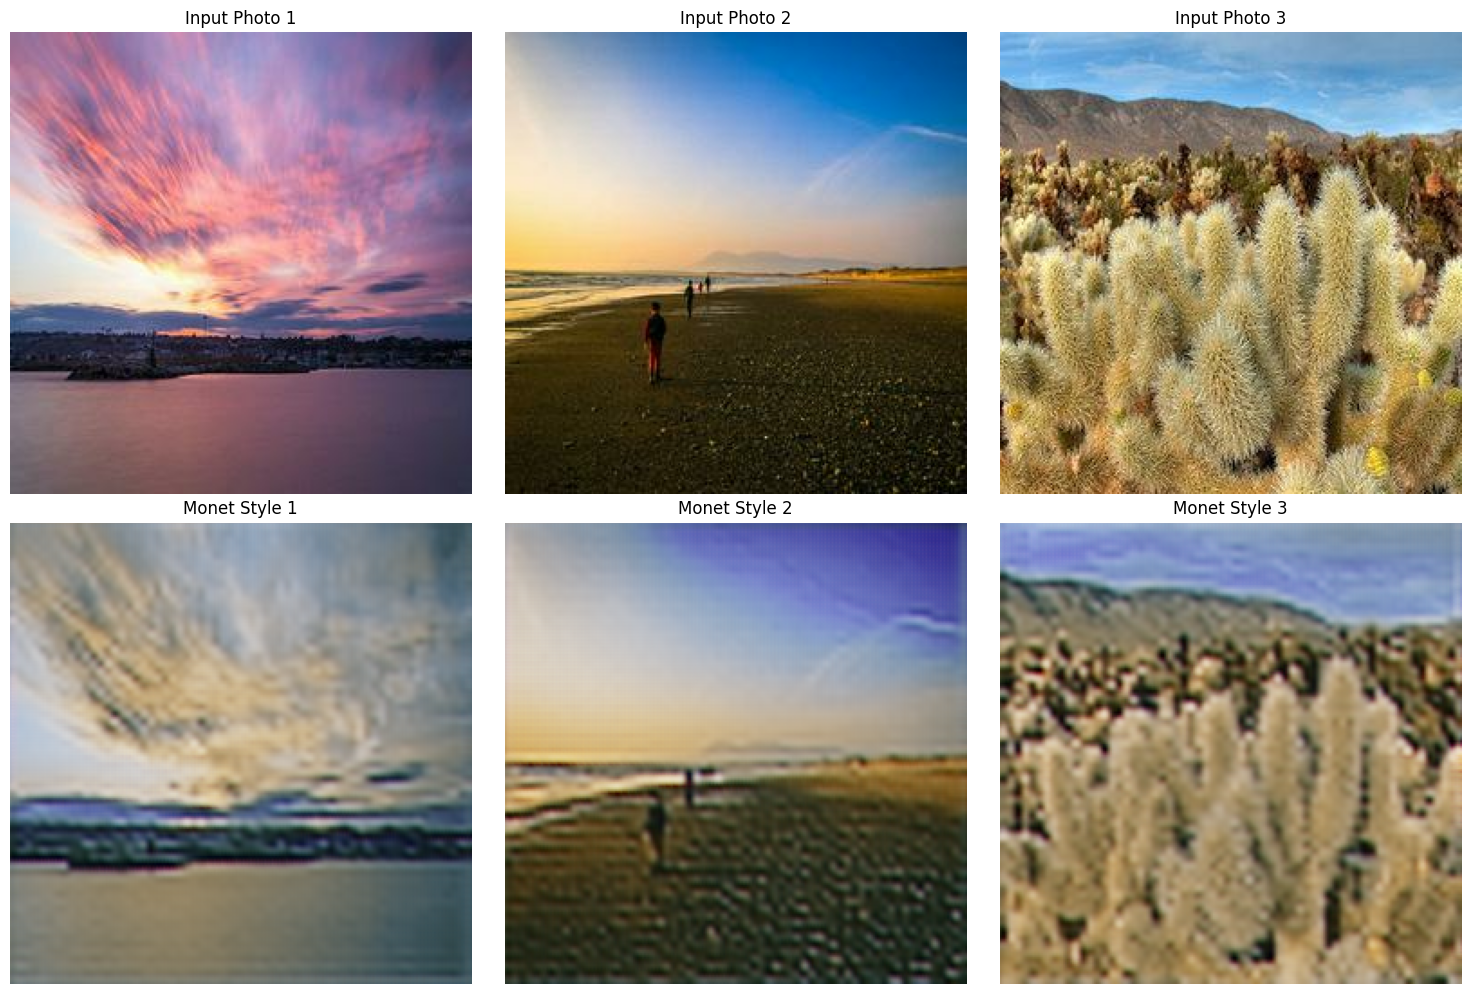

In [21]:
monet_style_images = []
for photo in photo_images:
  monet_style_image = monet_gen(tf.expand_dims(photo, axis=0))
  monet_style_images.append(monet_style_image[0])

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i in range(3):
    axes[0, i].imshow(photo_images[i])
    axes[0, i].set_title(f"Input Photo {i+1}")
    axes[0, i].axis("off")

    axes[1, i].imshow(monet_style_images[i])
    axes[1, i].set_title(f"Monet Style {i+1}")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()


In [22]:
import PIL
! mkdir ../images

In [23]:
i = 1
for img in photo_ds:
    prediction = monet_gen(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1
i

7039

In [24]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

# Conclusion

This was a very informative assignment.  In order to complete the assignement within the time-frame, I had to rely heavily on the tutorial recommend through Kaggle and the tutorial available through the Keras website.

One issue that I ran into was using the TPU on accelerator through the Kaggle notebook.  I spend hours reading documentation and trying to get it to work.  The model trained on the TPU through Google Colab, but in the Kaggle notebook it trained on the CPU, which was very slow.  So, I made additional modifications to the code and used the JPEG images in my model. The model now trains pretty quickly on the GPU, ~35s per epoch.

In the future, I would like to experiment more.  Use different architectures for the generators, use different optimizers, use different learning rates, use additional image augmentation techniques, and train with a higher epoch count.  The loss for the Monet generator decreases with each epoch.  So, a higher number of epochs should improve performance.  The descriminators seems to be working well.

While the model did not meet me initial hopes, in terms of performance, I learned alot.  I am confident that if I continue to work on the model, I can get near the top of the leaderboard.  Further, I now have a framework to work with for any other project involving style transfer with GANs.

# References

Along with the sources below, the AI tools included in Google Colab were also used at times during the compliation of this notebook.

**Kaggle Tutorial**

Jang, Amy, 2020, "Monet CycleGAN Tutorial": https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial.

**Keras Tutorial**

Nain, Aakash, 2020, "Implementation of CycleGAN": https://keras.io/examples/generative/cyclegan/